# Bayesian Forecaster

#### Imports

In [140]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

#### data setup

In [141]:
# importing data
experiment_type = "small"
data_directory = '../data/experiment_' + experiment_type + '/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (2,1, 0))

#reshaping and trimming
data = data.reshape(len(data),2*len(data[0]))
data_test = data[-365:,:]
data_val = data[-3*365:-365,:]
data_train = data[:-3*365,:]

diffs_test = np.diff(data_test, axis=0)
diffs_val = np.diff(data_val, axis=0)
diffs_train = np.diff(data_train, axis=0)

T,D = diffs_train.shape

# creating the dataframe
hospital_list = np.genfromtxt(data_directory + 'network_params/hospitals.txt', dtype=str, delimiter='\n', comments=None)
df_cols = np.array([[h + ' supply',h + ' demand'] for h in hospital_list]).reshape(D)
df = pd.DataFrame(diffs_train, columns=df_cols)

df

,Orange County supply,Orange County demand,Los Angeles supply,Los Angeles demand,Alta Bates supply,Alta Bates demand,Oakland supply,Oakland demand
0,-0.822526,4.916822,-0.651468,5.990946,-0.181573,1.195645,-0.153877,0.551387
1,-5.102420,-2.577938,-5.759107,-3.141480,-1.605124,-0.864180,-0.954659,-0.499657
2,-6.269205,-12.057078,-7.188447,-14.690660,-2.003511,-3.462579,-1.172944,-1.826633
3,0.079720,2.358417,0.267309,2.874134,0.074500,0.414624,0.014919,0.172501
4,-1.913910,-2.842920,-2.149450,-3.464546,-0.599088,-1.026598,-0.358112,-0.558890
...,...,...,...,...,...,...,...,...
1700,-4.477227,2.448968,-4.135527,3.899951,-1.152622,1.052343,-0.427141,0.540418
1701,0.916913,-12.227958,2.282668,-13.954272,0.636207,-2.929913,0.593405,-1.504606
1702,-0.431906,-0.849498,0.724342,-0.062672,0.201877,0.149546,0.350260,0.076791
1703,-0.229383,-6.185178,1.000272,-6.537077,0.278795,-1.301809,0.395280,-0.668523


#### constructing the BVAR model

In [144]:
def bvar_model(h,df,priors,draws=2000,tune=1000,chains=4,cores=4):
    coords = {
        "lags": np.arange(h)+1,
        "vars": df.columns.tolist(),
        "eqs": df.columns.tolist(),
        "time": [t for t in df.index[h:]]
    }

    with pm.Model(coords=coords) as model:
        # variable setup
        beta = pm.Normal(
            "beta",
            mu=priors["beta"]["mu"],
            sigma=priors["beta"]["sigma"],
            dims=("eqs","lags","vars")
        )
        alpha = pm.Normal(
            "alpha",
            mu=priors["alpha"]["mu"],
            sigma=priors["alpha"]["sigma"],
            dims=("eqs",)
        )
        data_obs = pm.Data(
            "data_obs",
            df.values[h:], 
            dims=("time","eqs"),
        )

        n = df.shape[1]

        # ar step
        ar = [
            pm.math.sum([
                pm.math.sum(beta[i,j]*df.values[h-(j+1):-(j+1)], axis=-1)
                for j in range(h)
            ], axis=0)
            for i in range(n)]
        mu = alpha + pm.math.stack(ar, axis=-1)
        sigma = pm.HalfNormal(
            "noise",
            sigma=priors["noise"]["sigma"],
            dims=["eqs"]
        )
        obs = pm.Normal(
            "obs",
            mu=mu,
            sigma=sigma,
            observed=data_obs ,
            dims=["time","eqs"]
            )

        #sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            random_seed=420,
            target_accept=0.95,
            sample='blackjax'
        )
    return model,trace

In [ ]:
h = 7

priors = {
    "beta": {"mu": 0.0, "sigma": 10.0},
    "alpha": {"mu": 0.0, "sigma": 10.0},
    "noise": {"sigma": 10.0}
}

model, trace = bvar_model(h, df, priors,draws=1000,tune=1000,chains=4,cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, noise]


Output()

#### looking at the model

In [111]:
az.summary(trace, var_names=["alpha", "beta","noise"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Orange County supply],-0.052,0.149,-0.335,0.232,0.013,0.009,139.0,224.0,1.03
alpha[Orange County demand],-0.018,0.166,-0.350,0.272,0.013,0.009,171.0,505.0,1.03
alpha[Los Angeles supply],-0.056,0.158,-0.369,0.217,0.012,0.009,170.0,348.0,1.03
alpha[Los Angeles demand],-0.020,0.153,-0.299,0.278,0.010,0.007,219.0,383.0,1.02
alpha[Alta Bates supply],-0.015,0.049,-0.109,0.076,0.004,0.003,150.0,317.0,1.02
...,...,...,...,...,...,...,...,...,...
noise[Los Angeles demand],6.284,0.106,6.066,6.483,0.010,0.007,113.0,143.0,1.03
noise[Alta Bates supply],1.847,0.030,1.787,1.903,0.002,0.001,263.0,479.0,1.02
noise[Alta Bates demand],1.618,0.032,1.556,1.677,0.005,0.004,38.0,17.0,1.07
noise[Oakland supply],0.843,0.015,0.817,0.871,0.002,0.001,68.0,279.0,1.06


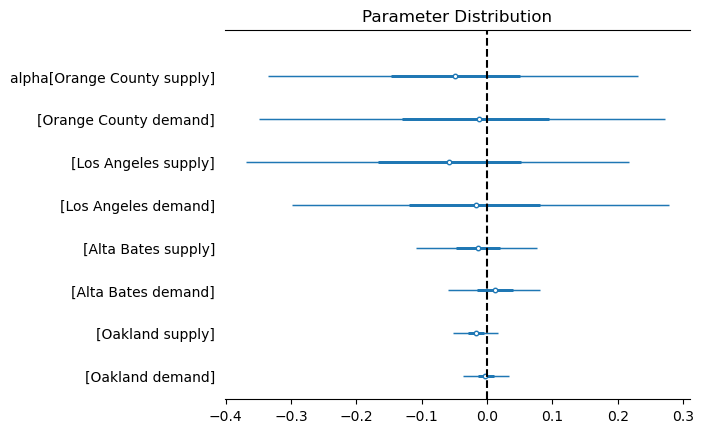

In [112]:
#fig, ax = plt.subplots(figsize=(20, 100))
az.plot_forest(trace, var_names=["alpha"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Parameter Distribution");

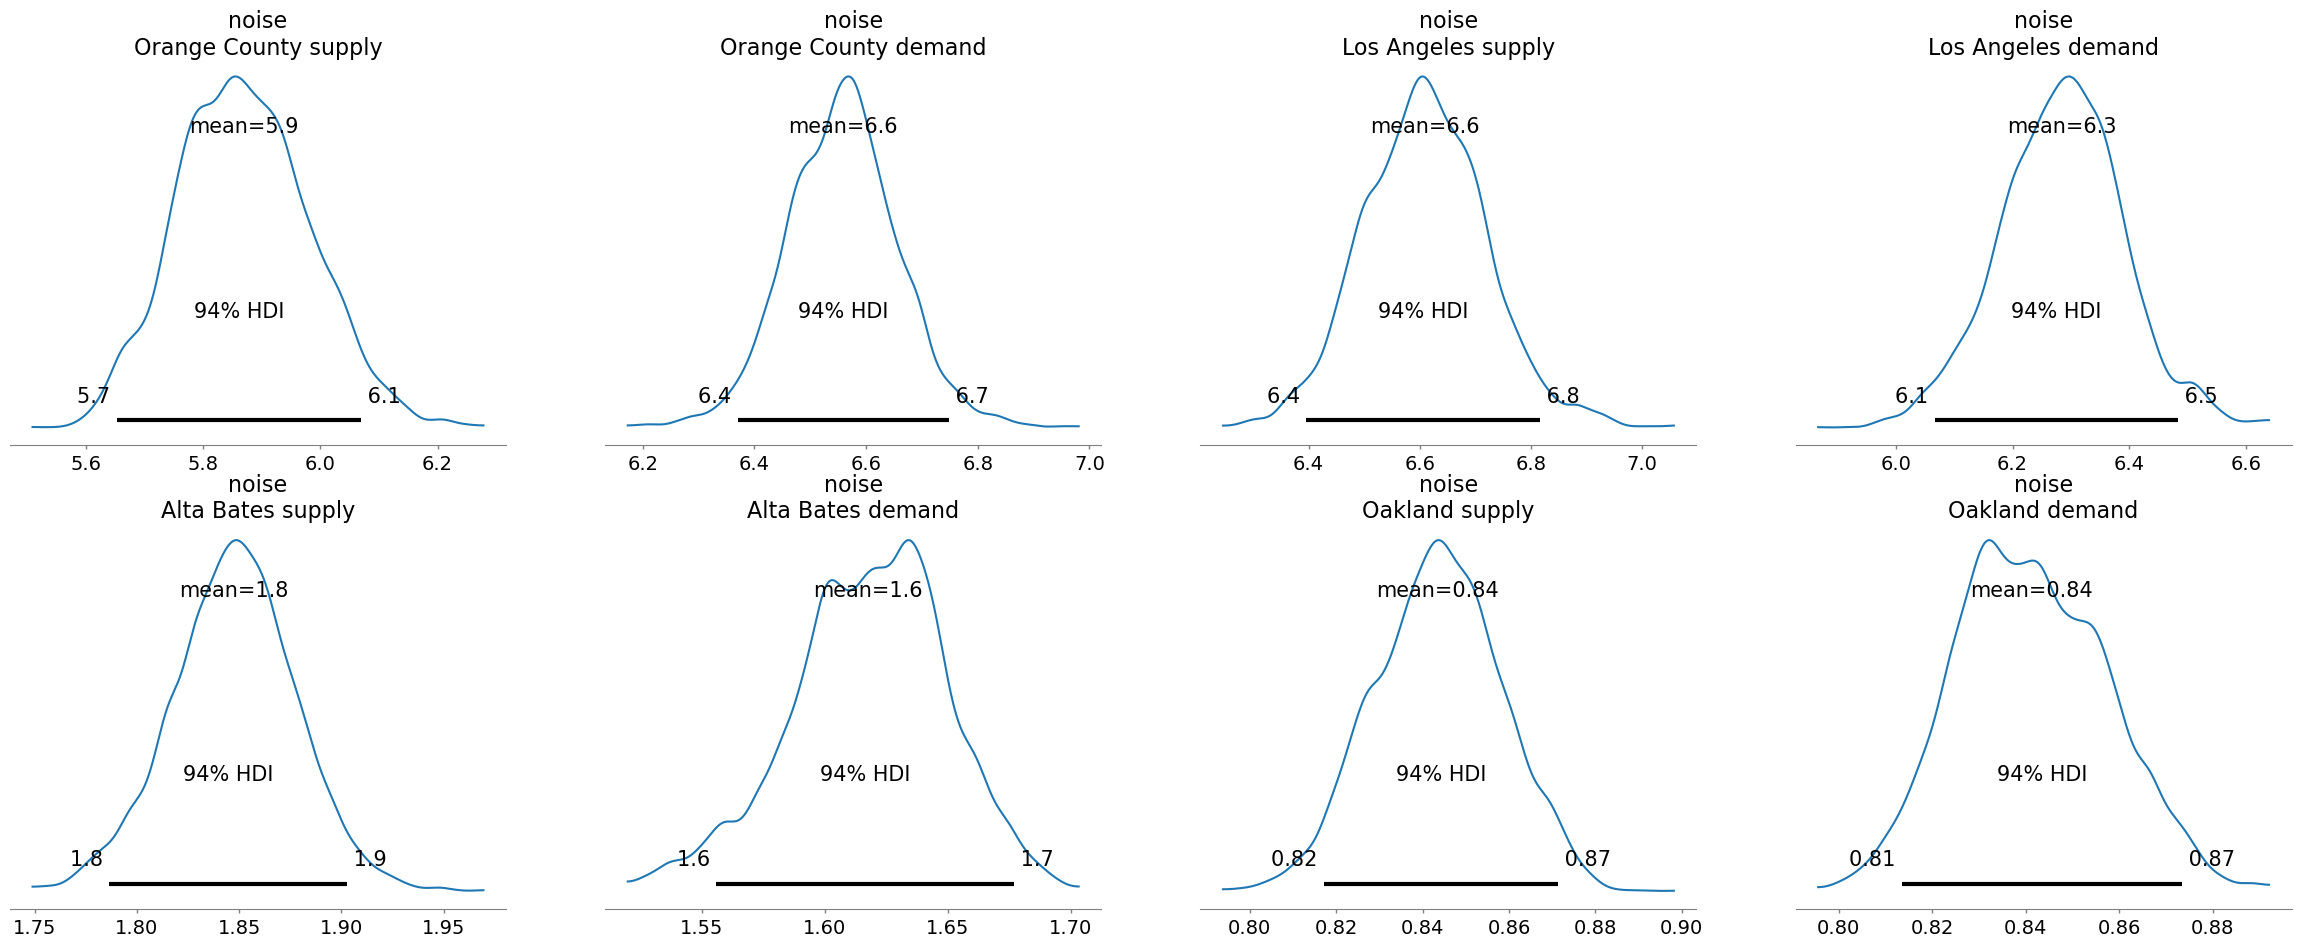

In [113]:
az.plot_posterior(trace, var_names=["noise"]);

#### forecasting

In [114]:
def get_posterior_sample(trace):
    beta_samples = trace.posterior["beta"].values  # Shape: (chains, samples, eqs, lags,variables)
    alpha_samples = trace.posterior["alpha"].values  # Shape: (chains,samples,eqs)
    noise_samples = trace.posterior["noise"].values  # Shape: (chains,samples,eqs)

    rand_chain = [np.random.randint(0,len(beta_samples)) for i in range(3)]
    rand_sample = [np.random.randint(0,len(beta_samples[0])) for i in range(3)]
    
    return alpha_samples[rand_chain[0],rand_sample[0]],beta_samples[rand_chain[1],rand_sample[1]],noise_samples[rand_chain[2],rand_sample[2]]

def get_prediction(trace,history,f):
    alpha_sample,beta_sample,noise_sample = get_posterior_sample(trace) # D x h x D, D, D
    history_resh = history.transpose(1, 0, 2).reshape(history.shape[1], 2*history.shape[0])  # h x D

    h,D = history_resh.shape
    forecast = np.zeros((f, D))

    noise=np.zeros((f,D))

    for n in range(D):
        noise[:,n] = np.random.normal(0,noise_sample[n],f)

    for t in range(f):
        forecast_t = noise[t] + alpha_sample
        
        for hist in range(h):
            forecast_t += np.dot(beta_sample[:, hist, :], history_resh[hist, :])
        
        forecast[t] = forecast_t
        history_resh = np.vstack((history_resh[1:], forecast_t))

    return forecast.reshape(f,D//2,2).transpose(1,0,2)

In [115]:
f = 3
history = diffs_train[-h:,:].reshape(h,D//2,2).transpose(1,0,2)
forecast = get_prediction(trace,history,f)

In [116]:
forecast[0]

array([[ -6.60964461,  10.24493779],
       [ 60.38905471,  56.71903114],
       [695.41668808, 756.05970508]])

In [117]:
diffs_val_resh = diffs_val.reshape(diffs_val.shape[0],diffs_val.shape[1]//2,2).transpose(1,0,2)
diffs_val_resh[0,:f,:]

array([[ 0.38325945, -2.92846446],
       [ 3.54767415, -1.40820687],
       [-5.07160922, -6.98452339]])